### audio processing

In [1]:
from scipy import ndimage
import sys
import librosa  # python package for music and audio analysis
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks.callbacks import ReduceLROnPlateau, ModelCheckpoint
# import efficientnet.tfkeras as efn #Convolutional Neural Network architecture
# from efficientnet.keras import center_crop_and_resize, preprocess_input
from sklearn.utils import class_weight
import seaborn as sns
import skimage.transform as st
import skimage.io

/Users/advikabattini/anaconda/envs/birdsong/lib/python3.6/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


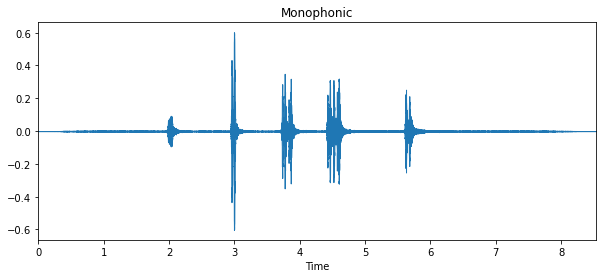

In [2]:
SOUND_DIR="downloads/Nuttall's Woodpecker/audio_file.mp3"
# listen to the recording
ipd.display(ipd.Audio(SOUND_DIR,rate=48000))

# load the mp3 file
signal, sr = librosa.load(SOUND_DIR,duration=48000) # sr = sampling rate

# plot recording signal
plt.figure(figsize=(10, 4))
librosa.display.waveplot(signal, sr=sr)
plt.title('Monophonic')
plt.show()

(2.5, 2.505)

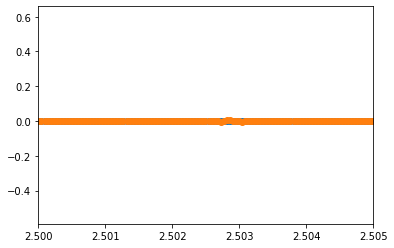

In [3]:
time=np.linspace(1,len(signal),len(signal))/sr
sig = signal.copy()
noise = signal.copy()
sig[np.abs(sig) <abs(20000*signal.mean())] = 0
noise[np.abs(noise) >= abs(20000*signal.mean())] = 0
plt.scatter(time,sig)
plt.scatter(time,noise)
plt.xlim(2.5, 2.505)

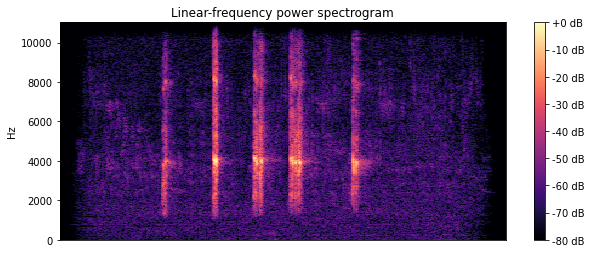

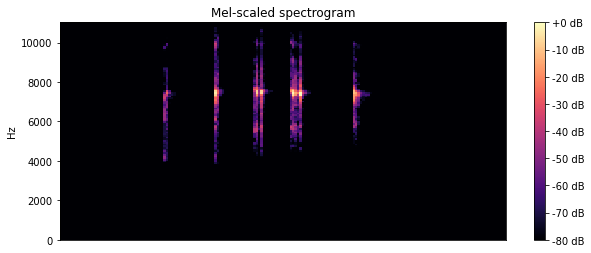

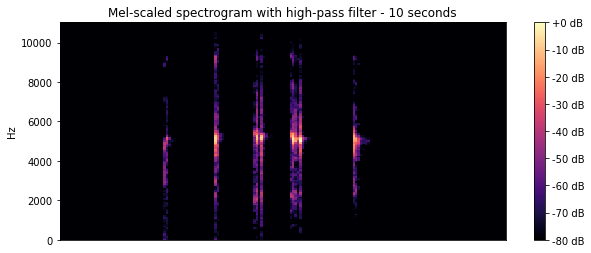

In [4]:
# Plot spectogram
plt.figure(figsize=(10, 4))
D = librosa.amplitude_to_db(np.abs(librosa.stft(signal)), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.show()

# Plot mel-spectrogram
N_FFT = 1024         
HOP_SIZE = 1024       
N_MELS = 128            
WIN_SIZE = 1024      
WINDOW_TYPE = 'hann' 
FEATURE = 'mel'      
FMIN = 0 

S = librosa.feature.melspectrogram(y=signal,sr=sr,
                                    n_fft=N_FFT,
                                    hop_length=HOP_SIZE, 
                                    n_mels=N_MELS, 
                                    htk=True, 
                                    fmin=FMIN, 
                                    fmax=sr/2) 

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S**2,ref=np.max), fmin=FMIN,y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-scaled spectrogram')
plt.show()

# Plot mel-spectrogram with high-pass filter
N_FFT = 1024         
HOP_SIZE = 1024       
N_MELS = 128            
WIN_SIZE = 1024      
WINDOW_TYPE = 'hann' 
FEATURE = 'mel'      
FMIN = 1400 

S = librosa.feature.melspectrogram(y=signal,sr=sr,
                                    n_fft=N_FFT,
                                    hop_length=HOP_SIZE, 
                                    n_mels=N_MELS, 
                                    htk=True, 
                                    fmin=FMIN, 
                                    fmax=sr/2) 

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S**2,ref=np.max), fmin=FMIN,y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-scaled spectrogram with high-pass filter - 10 seconds')
plt.show()

### Signal extraction

In [5]:
x = np.abs(librosa.stft(signal))
mat = x/np.max(x)

col_medians = np.median(mat,axis=0)
row_medians = np.median(mat,axis=1)

row_mat = mat >= 4*row_medians.reshape(-1,1)
col_mat = mat >= 4*col_medians.reshape(1,-1)
filter_1 = row_mat & col_mat
filter_1.astype(int)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

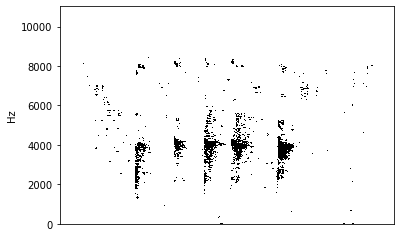

In [6]:
librosa.display.specshow(filter_1, y_axis='linear')

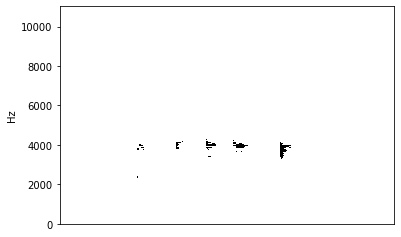

In [7]:
erosion_filter = ndimage.binary_erosion(filter_1, structure=np.ones((4,4))).astype(filter_1.dtype)
librosa.display.specshow(erosion_filter, y_axis='linear')

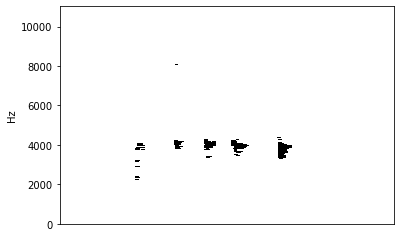

In [8]:
dilation_filter = ndimage.binary_dilation(erosion_filter, structure=np.ones((4,4))).astype(erosion_filter.dtype)
librosa.display.specshow(dilation_filter,  y_axis='linear')

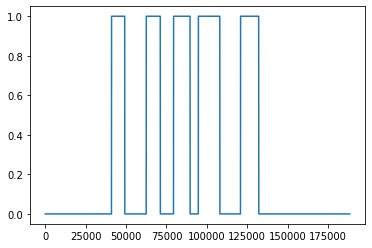

In [9]:
temp_filter = np.sum(dilation_filter,axis=0)
column_mask = (temp_filter >= 1).reshape(-1,1)

column_mask= ndimage.binary_dilation(column_mask, structure=np.ones((4,1))).astype(column_mask.dtype)
column_mask = ndimage.binary_dilation(column_mask, structure=np.ones((4,1))).astype(column_mask.dtype)


b_bird = st.resize(column_mask, (signal.shape[0], 1))
b_bird = b_bird.astype(bool)
plt.plot(b_bird)

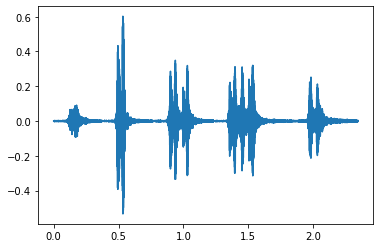

In [10]:
bird_sig = signal[b_bird[:,0]].copy()
x=np.linspace(1,len(bird_sig),len(bird_sig))/sr
plt.plot(x,bird_sig)


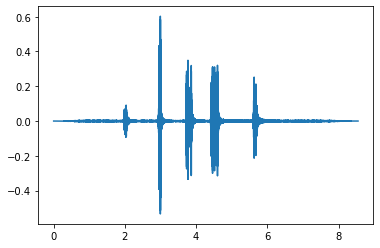

In [11]:
x=np.linspace(1,len(signal),len(signal))/sr
plt.plot(x,signal)

### noise extraction

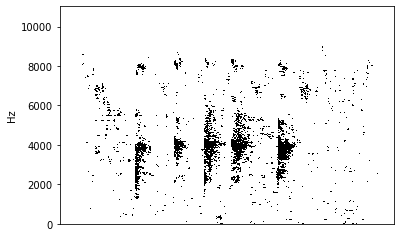

In [12]:
x = np.abs(librosa.stft(signal))
mat = x/np.max(x)

col_medians = np.median(mat,axis=0)
row_medians = np.median(mat,axis=1)

row_mat = mat > 3*row_medians.reshape(-1,1)
col_mat = mat > 3*col_medians.reshape(1,-1)
filter_1 = row_mat & col_mat
filter_1.astype(int)
librosa.display.specshow(filter_1, y_axis='linear')

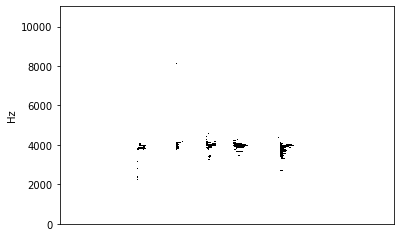

In [13]:
erosion_filter = ndimage.binary_erosion(filter_1, structure=np.ones((4,4))).astype(filter_1.dtype)
librosa.display.specshow(erosion_filter, y_axis='linear')

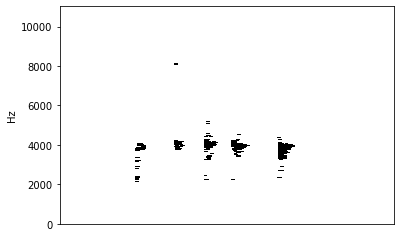

In [14]:
dilation_filter = ndimage.binary_dilation(erosion_filter, structure=np.ones((4,4))).astype(erosion_filter.dtype)
librosa.display.specshow(dilation_filter,  y_axis='linear')

In [15]:
temp_filter = np.sum(dilation_filter,axis=0)
column_mask1 = (temp_filter < 1).reshape(-1,1)

column_mask1= ndimage.binary_dilation(column_mask1, structure=np.ones((4,1))).astype(column_mask1.dtype)
column_mask1 = ndimage.binary_dilation(column_mask1, structure=np.ones((4,1))).astype(column_mask1.dtype)



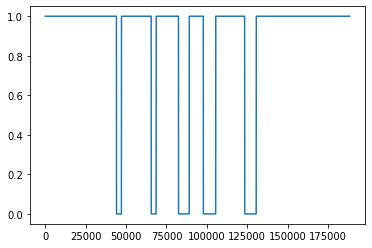

In [16]:
b_noise = st.resize(column_mask1, (signal.shape[0], 1))
b_noise = b_noise.astype(bool)
plt.plot(b_noise)

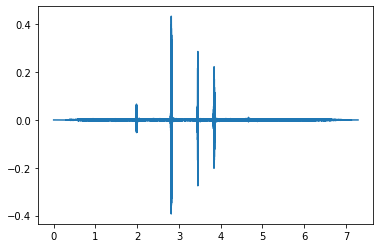

In [17]:
noise = signal[b_noise[:,0]].copy()
x=np.linspace(1,len(noise),len(noise))/sr
plt.plot(x,noise)



### overlapped viz

In [18]:
t1, t2 = signal.copy(), signal.copy()

t1[np.invert(b_bird[:,0])]=0
t2[np.invert(b_noise[:,0])]=0 

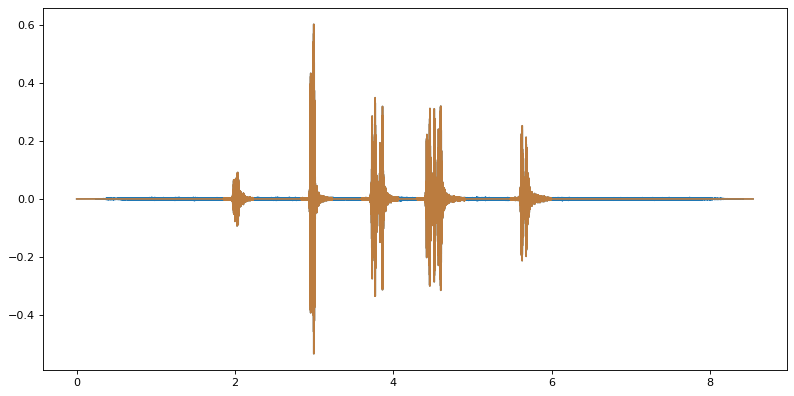

In [19]:
x=np.linspace(1,len(signal),len(signal))/sr
plt.figure(figsize=(12, 6), dpi=80)
plt.plot(x,signal)
plt.plot(x,t1,alpha=0.7)


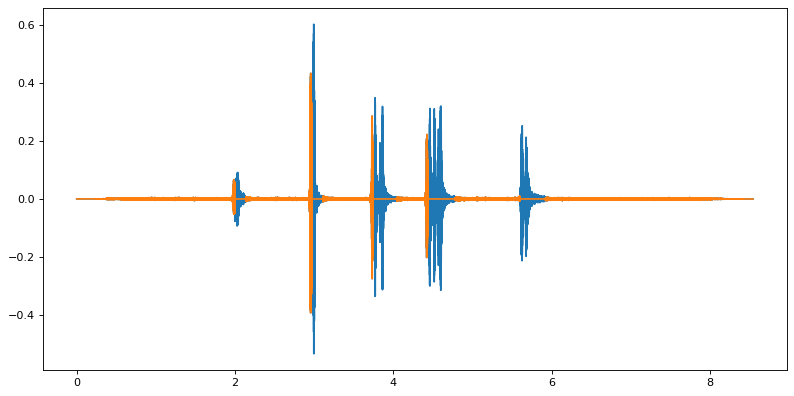

In [20]:
plt.figure(figsize=(12, 6), dpi=80)
plt.plot(x,signal)
plt.plot(x,t2)

### Divide into chunks

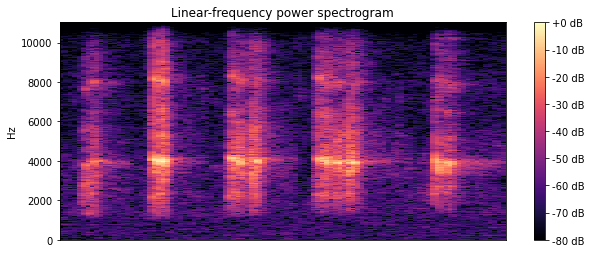

In [21]:

plt.figure(figsize=(10, 4))
D = librosa.amplitude_to_db(np.abs(librosa.stft(bird_sig)), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.show()

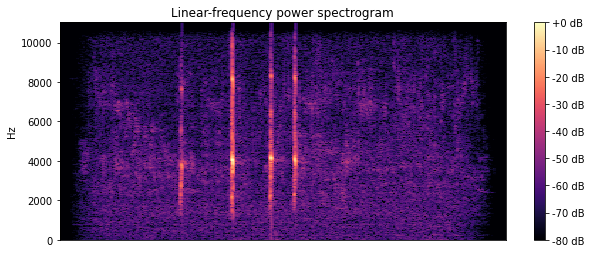

In [22]:
plt.figure(figsize=(10, 4))
D = librosa.amplitude_to_db(np.abs(librosa.stft(noise)), ref=np.max)
noise_img = librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.savefig("_plot_static_conv.png")

plt.show()

## Data Augmentation